In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
b = pd.read_csv("/content/sample_data/csv_building_structure.csv")
df = pd.read_csv("/content/sample_data/ward_vdcmun_district_name_mapping.csv")

In [ ]:
df=df[['district_id','district_name']]

In [ ]:
# district_id'si ve district_name'i aynı olan satırları silme
df = df.drop_duplicates(subset=['district_id', 'district_name'], keep='first')

In [ ]:
# damage_grade'i boş olan satırları silme
b = b.dropna(subset=['damage_grade'])

In [ ]:
# Bina yapım yılı kolonu eklenmesi
today = datetime.date.today()

year = today.year

b['building_creation_year'] = 2015 - b['age_building']

In [ ]:
# Floatları integer'a çevirme
for column in b.columns:
  if b[column].dtype == 'float64':
    b[column] = b[column].fillna(0).astype(int)

In [ ]:
# Hasar seviyesini Stringden integer'a çevirme
def extract_grade_number(grade):
  if pd.isnull(grade):
    return np.nan
  else:
    return int(grade.split()[-1])

b['damage_grade'] = b['damage_grade'].apply(extract_grade_number)

In [ ]:
# Tutarsız verileri silme

b = b.drop(b[(b['damage_grade'] == 5) & ((b['height_ft_pre_eq'] == b['height_ft_post_eq']) | (b['count_floors_pre_eq'] == b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 4) & ((b['height_ft_pre_eq'] == b['height_ft_post_eq']) | (b['count_floors_pre_eq'] == b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 1) & ((b['height_ft_pre_eq'] != b['height_ft_post_eq']) & (b['count_floors_pre_eq'] != b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 3) & ((b['height_ft_pre_eq'] == 0) | (b['count_floors_pre_eq'] == 0))].index)
b = b.drop(b[(b['damage_grade'] != 5) & ((b['height_ft_pre_eq'] == 0) | (b['count_floors_pre_eq'] == 0))].index)
b = b[b['building_creation_year'] <= 2010]

# Teknik çözüme göre tutarsız verileri silme

b = b.drop(b[(b['damage_grade'] == 1) & ((b['height_ft_pre_eq'] > b['height_ft_post_eq']) | (b['count_floors_pre_eq'] > b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] <= 2) & (b['technical_solution_proposed'] == 'Reconstruction')].index)
b = b.drop(b[(b['damage_grade'] <= 2) & (b['technical_solution_proposed'] == 'Major repair')].index)
b = b.drop(b[(b['damage_grade'] == 5) & (b['technical_solution_proposed'] != 'Reconstruction')].index)
b = b.drop(b[(b['damage_grade'] == 4) & (b['technical_solution_proposed'] == 'Minor repair')].index)
b = b.drop(b[(b['age_building'] > 50) & (b['damage_grade'] == 2)].index)
b = b.drop(b[(b['condition_post_eq'] == 'Damaged-Used in risk') & (b['damage_grade'] == 5)].index)

In [ ]:
# b ve df verisetleri district_id'ye göre birleştirildi

merged_df = pd.merge(b, df[['district_id', 'district_name']], on='district_id', how='left')

In [ ]:
# İlçelere göre hissedilen deprem büyüklükleri ve bu büyüklükleri birbirlerine göre katları eklendi

merged_df.loc[merged_df['district_name'] == 'Okhaldhunga', 'magnitude_felt'] = 1
merged_df.loc[merged_df['district_name'] == 'Okhaldhunga', 'magnitude'] = 5.5
merged_df.loc[merged_df['district_name'] == 'Sindhuli', 'magnitude_felt'] = 5
merged_df.loc[merged_df['district_name'] == 'Sindhuli', 'magnitude'] = 6.25
merged_df.loc[merged_df['district_name'] == 'Ramechhap', 'magnitude_felt'] = 20
merged_df.loc[merged_df['district_name'] == 'Ramechhap', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Dolakha', 'magnitude_felt'] = 80
merged_df.loc[merged_df['district_name'] == 'Dolakha', 'magnitude'] = 7.3
merged_df.loc[merged_df['district_name'] == 'Sindhupalchok', 'magnitude_felt'] = 40
merged_df.loc[merged_df['district_name'] == 'Sindhupalchok', 'magnitude'] = 7.0
merged_df.loc[merged_df['district_name'] == 'Kavrepalanchok', 'magnitude_felt'] = 18
merged_df.loc[merged_df['district_name'] == 'Kavrepalanchok', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Nuwakot', 'magnitude_felt'] = 30
merged_df.loc[merged_df['district_name'] == 'Nuwakot', 'magnitude'] = 6.9
merged_df.loc[merged_df['district_name'] == 'Rasuwa', 'magnitude_felt'] = 20
merged_df.loc[merged_df['district_name'] == 'Rasuwa', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Dhading', 'magnitude_felt'] = 40
merged_df.loc[merged_df['district_name'] == 'Dhading', 'magnitude'] = 7.0
merged_df.loc[merged_df['district_name'] == 'Makwanpur', 'magnitude_felt'] = 11
merged_df.loc[merged_df['district_name'] == 'Makwanpur', 'magnitude'] = 6.5
merged_df.loc[merged_df['district_name'] == 'Gorkha', 'magnitude_felt'] = 250
merged_df.loc[merged_df['district_name'] == 'Gorkha', 'magnitude'] = 7.8

In [ ]:
b=merged_df

NameError: name 'merged_df' is not defined

In [ ]:
# Tutarsız veriler siliniyor

result_df_1 = b[(b['age_building'] > 70) & (b['count_floors_pre_eq'] >= 3) & (b['height_ft_post_eq'] != 0) & (b['damage_grade'] == 3)]
b = b.drop(result_df_1.index)
result_df_2 = b[(b['age_building'] > 100) & (b['count_floors_pre_eq'] >= 2) & (b['height_ft_post_eq'] != 0) & (b['damage_grade'] == 3)]
b = b.drop(result_df_2.index)
result_df_3 = b[(b['age_building'] > 70) & (b['magnitude'] >= 6) & (b['damage_grade'] == 1)]
b = b.drop(result_df_3.index)
result_df_4 = b[(b['age_building'] > 130)]
b = b.drop(result_df_4.index)
result_df_5 = b[(b['plinth_area_sq_ft'] > 700)]
b = b.drop(result_df_5.index)
result_df_6 = b[(b['height_ft_pre_eq'] >= 40)]
b = b.drop(result_df_6.index)

In [ ]:
# Hasar seviyesi 2 ve 3 olanlar artık 2
# 4 ve 5 olanlar da 3 olacak
b.loc[b['damage_grade'].isin([2, 3]), 'damage_grade'] = 2
b.loc[b['damage_grade'].isin([4, 5]), 'damage_grade'] = 3

In [8]:
b = pd.read_csv("/content/sample_data/data.csv")

In [9]:
# prompt: herhangi bir sütunu boş olan satırları silen kod (b için)

# Assuming 'b' is your DataFrame
b = b.dropna()

In [10]:
# prompt: damage_grade'i 3 olup'da count_floors_pre_eq'su count_floors_post_eq'su ile eşit olan satırları sil

# Assuming 'b' is your DataFrame and it's already loaded and preprocessed as in your original code.

b = b[~((b['damage_grade'] == 1) & (b['count_floors_pre_eq'] != b['count_floors_pre_eq']))]
b = b[~((b['damage_grade'] == 2) & (b['count_floors_pre_eq'] == b['count_floors_post_eq']))]
b = b[~((b['damage_grade'] == 3) & (b['count_floors_post_eq'] != 0))]

b = b[~((b['damage_grade'] == 1) & (b['height_ft_pre_eq'] != b['height_ft_pre_eq']))]
b = b[~((b['damage_grade'] == 2) & (b['height_ft_pre_eq'] == b['height_ft_post_eq']))]
b = b[~((b['damage_grade'] == 3) & (b['height_ft_post_eq'] != 0))]

In [5]:
pd.set_option('display.max_columns', 500)
b

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,building_creation_year,district_name,magnitude_felt,magnitude
3,120101000051,12.0,1207.0,120703.0,1.0,1.0,30.0,308.0,9.0,9.0,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Repaired and used,1.0,Minor repair,1985.0,Okhaldhunga,1.0,5.5
5,120101000071,12.0,1207.0,120703.0,1.0,0.0,13.0,234.0,9.0,0.0,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Rubble unclear,3.0,Reconstruction,2002.0,Okhaldhunga,1.0,5.5
9,120101000121,12.0,1207.0,120703.0,2.0,2.0,15.0,528.0,21.0,21.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not damaged,1.0,Minor repair,2000.0,Okhaldhunga,1.0,5.5
10,120101000131,12.0,1207.0,120703.0,2.0,2.0,18.0,528.0,21.0,21.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Repaired and used,1.0,No need,1997.0,Okhaldhunga,1.0,5.5
12,120101000161,12.0,1207.0,120703.0,2.0,2.0,7.0,330.0,19.0,19.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Repaired and used,1.0,No need,2008.0,Okhaldhunga,1.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106450,221609000781,22.0,2208.0,220806.0,3.0,0.0,25.0,390.0,17.0,0.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Rubble unclear,3.0,Reconstruction,1990.0,Dolakha,80.0,7.3
106451,221609000791,22.0,2208.0,220806.0,1.0,0.0,5.0,290.0,6.0,0.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Rubble clear,3.0,Reconstruction,2010.0,Dolakha,80.0,7.3
106453,221609000882,22.0,2208.0,220806.0,1.0,1.0,6.0,305.0,7.0,7.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not damaged,1.0,Minor repair,2009.0,Dolakha,80.0,7.3
106457,221609000951,22.0,2208.0,220806.0,2.0,0.0,50.0,290.0,13.0,0.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Rubble unclear,3.0,Reconstruction,1965.0,Dolakha,80.0,7.3


<ipython-input-12-46c0596e9153>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-12-46c0596e9153>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-12-46c0596e9153>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

XGBoost Accuracy: 0.845
Random Forest Accuracy: 0.935


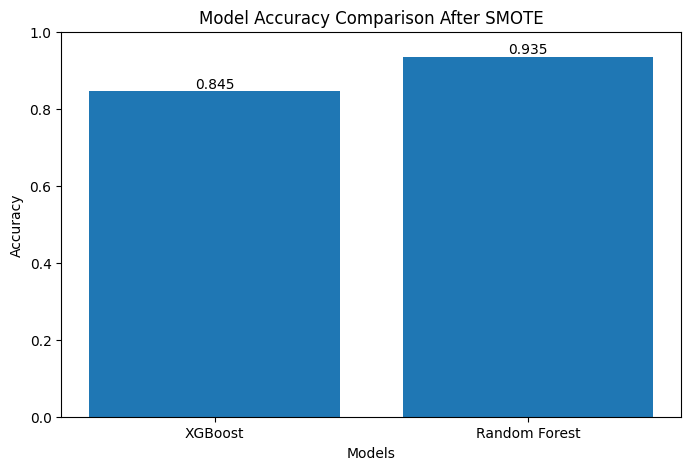

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
import matplotlib.pyplot as plt

data = b

# Özellikler ve hedef değişken
features = [
    "plinth_area_sq_ft",
    "magnitude_felt",
    "magnitude",
    "land_surface_condition",
    "count_floors_pre_eq",
    "height_ft_pre_eq",
    "roof_type",
    "age_building",
    "foundation_type",
    "ground_floor_type",
    "other_floor_type",
    "has_superstructure_adobe_mud",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
]

target = "damage_grade"

X = data[features]
y = data[target] - 1

# Kategorik değişkenleri dönüştürme
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# SMOTE ile dengesizlik giderme
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model eğitim ve değerlendirme
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", round(xgb_accuracy, 3))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", round(rf_accuracy, 3))

# Logistic Regression
# logr = linear_model.LogisticRegression(max_iter=500)
# logr.fit(X_train, y_train)
# logr_predictions = logr.predict(X_test)
# logr_accuracy = accuracy_score(y_test, logr_predictions)
# print("Logistic Regression Accuracy:", round(logr_accuracy, 3))

# Doğruluk oranlarını görselleştirme
model_names = ['XGBoost', 'Random Forest']
accuracies = [xgb_accuracy, rf_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison After SMOTE")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.bar_label(plt.bar(model_names, accuracies), fmt='%.3f')
plt.show()

<ipython-input-13-9d2357ab5ec5>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-13-9d2357ab5ec5>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-13-9d2357ab5ec5>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

XGBoost Accuracy: 0.746
Random Forest Accuracy: 0.735


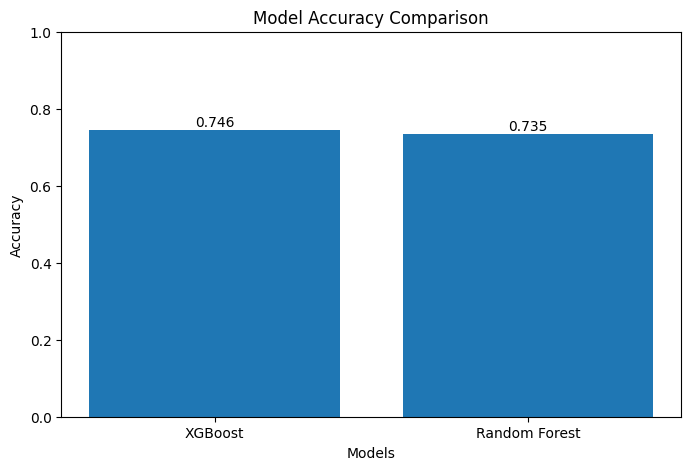

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


# ... (Your existing code for data loading and preprocessing)

# Sample equal number of instances for each damage grade
damage_grade_counts = data['damage_grade'].value_counts()
min_count = min(damage_grade_counts)
sampled_data = pd.DataFrame()
for grade in range(1, 4): # Assuming damage_grades are 1, 2 and 3
    grade_data = data[data['damage_grade'] == grade].sample(n=min_count, random_state=42) # Adjust random_state if needed
    sampled_data = pd.concat([sampled_data, grade_data], ignore_index=True)

# Special features and target variable
features = [
    "plinth_area_sq_ft",
    "magnitude_felt",
    "magnitude",
    "land_surface_condition",
    "count_floors_pre_eq",
    "height_ft_pre_eq",
    "roof_type",
    "age_building",
    "foundation_type",
    "ground_floor_type",
    "other_floor_type",
    "has_superstructure_adobe_mud",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
]
target = "damage_grade"

X = sampled_data[features]  # Use sampled_data here
y = sampled_data[target] - 1  # Use sampled_data here


# Convert categorical features to numerical using Label Encoding
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to store feature weights
feature_weights = {
    "magnitude_felt": 5,
    "magnitude": 5,
    "roof_type": 2,
    "age_building":5,
    "ground_floor_type": 2,
    "other_floor_type": 2,
    "foundation_type":4,
    "has_superstructure_cement_mortar_stone":2,
    "has_superstructure_mud_mortar_brick":2,
    "has_superstructure_cement_mortar_brick":2,
}

# Assign weights to features in X_train and X_test
for feature, weight in feature_weights.items():
    if feature in X_train.columns:
        X_train[feature] = X_train[feature] * weight
    if feature in X_test.columns:
        X_test[feature] = X_test[feature] * weight


# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", round(xgb_accuracy, 3))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", round(rf_accuracy, 3))

import matplotlib.pyplot as plt

# Doğruluk değerlerini listeye ekle
model_names = ['XGBoost', 'Random Forest']
accuracies = [xgb_accuracy, rf_accuracy]

# Grafik oluştur
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)  # Doğruluk oranları 0-1 arasında olduğundan eksen sınırlarını ayarlayın
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(model_names)
plt.bar_label(plt.bar(model_names, accuracies), fmt='%.3f')  # Doğrulukları sütun üzerinde göster
plt.show()

<ipython-input-77-cd63512d8ed8>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-77-cd63512d8ed8>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-77-cd63512d8ed8>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

XGBoost Accuracy: 0.927
Random Forest Accuracy: 0.924


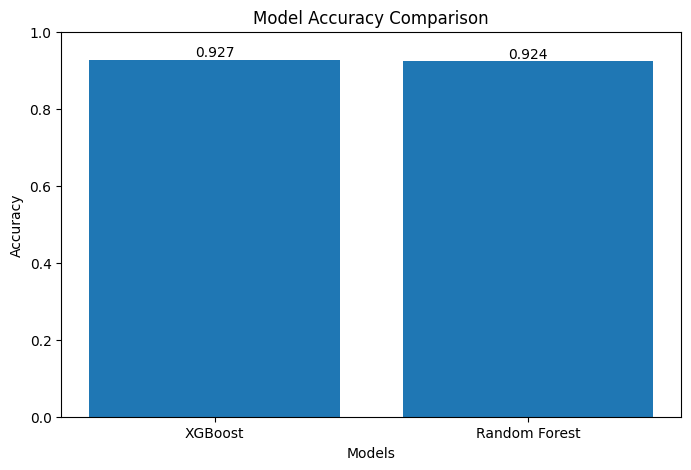

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
# ... (Your existing code) ...

# Assuming your DataFrame is named 'b' and the code you provided has been executed
data = b

# Select features and target variable
features = [
    "plinth_area_sq_ft",
    "magnitude_felt",
    "magnitude",
    "land_surface_condition",
    "count_floors_pre_eq",
    "height_ft_pre_eq",
    "roof_type",
    "age_building",
    "foundation_type",
    "ground_floor_type",
    "other_floor_type",
    "has_superstructure_adobe_mud",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
]

target = "damage_grade"

X = data[features]
y = data[target] - 1

# Convert categorical features to numerical using Label Encoding
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to store feature weights
feature_weights = {
    "magnitude_felt": 5,
    "magnitude": 5,
    "roof_type": 2,
    "age_building":5,
    "ground_floor_type": 2,
    "other_floor_type": 2,
    "foundation_type":4,
    "has_superstructure_cement_mortar_stone":2,
    "has_superstructure_mud_mortar_brick":2,
    "has_superstructure_cement_mortar_brick":2,
}

# Assign weights to features in X_train and X_test
for feature, weight in feature_weights.items():
    if feature in X_train.columns:
        X_train[feature] = X_train[feature] * weight
    if feature in X_test.columns:
        X_test[feature] = X_test[feature] * weight


# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", round(xgb_accuracy, 3))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", round(rf_accuracy, 3))

import matplotlib.pyplot as plt

# Doğruluk değerlerini listeye ekle
model_names = ['XGBoost', 'Random Forest']
accuracies = [xgb_accuracy, rf_accuracy]

# Grafik oluştur
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)  # Doğruluk oranları 0-1 arasında olduğundan eksen sınırlarını ayarlayın
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(model_names)
plt.bar_label(plt.bar(model_names, accuracies), fmt='%.3f')  # Doğrulukları sütun üzerinde göster
plt.show()